# CMPE-274 Business Intelligence Project

## Submitted by -  Supreeth Chandrasekhar, Abhishek Ganesan, Anay Naik, and Rooppesh Sarankapani

We are combining the gun violence dataset with the county health data. The gun violence data was downloaded from gunviolencearchive.org. It has 239,677 observations and 29 columns for the years 2013–2018 with a row for each gun incident. To limit the scope, we filtered the file to use only the 2017 gun violence data, which contains 59,881 observations. The county health file has data for a similar timeframe (2010- 2017) but is aggregated by state and county. This file has 3,142 observations with 164 columns and 99 columns over two tabs. 

The three datasets (.csv) files present in the datasets folder here</a> 

## Import Libraries and Data

In [238]:
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
%matplotlib inline

# setting max rows and columns to display in notebook as 50 for ease of reading.
pd.set_option('max_rows', 50);
pd.set_option('max_columns', 50);

### Merging the two datasets

The code below is commented out, because it taked approximately 7.5 hoursto run. This is used to get the FIPS code for each county using the latitude and longitude values in the gun violence dataset. This is then added to the gun violence dataset in order to join the gun violence and county health data on the FIPS column. The prepared dataset is available in the datasets folder here.

In [239]:
#import requests

#gun_violence_with_FIPS = pd.read_csv('datasets/gun-violence-data_2017.csv');
#lat=0
#long=0
#gun_violence_with_FIPS['derived_county_FIPS'] = ''

#for row in gun_violence_with_FIPS.iterrows():
#    lat=gun_violence_with_FIPS.latitude[row[0]]
#    long=gun_violence_with_FIPS.longitude[row[0]]
#    parameters={'latitude':lat, 'longitude':long, 'format':'json'}
#    url = 'https://geo.fcc.gov/api/census/block/find?'
#    resp = requests.get(url, params=parameters)
#    census_dict = resp.json()
#    census_counties_dict = census_dict['County']
#    gun_violence_with_FIPS.derived_county_FIPS[row[0]] = census_counties_dict['FIPS']

#gun_violence_with_FIPS.to_csv('gun_violence_with_FIPS.csv', index=False)

In [240]:
import os
from math import*


In [241]:
# load initial files into dataframes
gunViolence_df = pd.read_csv('datasets/gun_violence_with_FIPS.csv'); # gun violence data with county FIPS added from FCC's API
countyHealth_df1 = pd.read_excel('datasets/2018CountyHealthRankingsData-v1.xls', 'Ranked Measure Data', skiprows=1); # county health
countyHealth_df2 = pd.read_excel('datasets/2018CountyHealthRankingsData-v1.xls', 'Additional Measure Data', skiprows=1); # county health

# Initial Data Analysis

Here is the structure of the dataset including number of features, data types, statistical measures and missing values. 

In [242]:
gunViolence_df.describe() 

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district,derived_county_FIPS
count,5.988100e+04,59881.000000,59881.000000,57875.000000,59881.000000,59881.000000,59746.000000,50511.000000,53396.000000,59879.000000
mean,8.796688e+05,0.251733,0.500292,7.879084,37.599829,-89.421870,1.242058,54.364198,20.448648,26756.549508
std,8.041492e+04,0.513046,0.713785,8.312070,5.053646,14.336144,1.848118,44.573474,14.337983,15360.038221
min,7.393300e+05,0.000000,0.000000,0.000000,19.201700,-165.711000,1.000000,1.000000,1.000000,1001.000000
25%,8.124530e+05,0.000000,0.000000,2.000000,33.974600,-93.738000,1.000000,19.000000,8.000000,13051.000000
50%,8.775330e+05,0.000000,0.000000,5.000000,38.639800,-86.650200,1.000000,46.000000,18.000000,25021.000000
75%,9.438690e+05,0.000000,1.000000,10.000000,41.449100,-80.081400,1.000000,81.000000,30.000000,39113.000000
max,1.083162e+06,27.000000,25.000000,53.000000,71.336800,90.370000,50.000000,901.000000,67.000000,56043.000000


In [243]:
#let's plot a graph of number of gun violence incidents to the states to have a visual clarity.
states_df = gunViolence_df['state'].value_counts()

statesdf = pd.DataFrame()
statesdf['state'] = states_df.index
statesdf['counts'] = states_df.values

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

state_to_code = {'District of Columbia' : 'dc','Mississippi': 'MS', 'Oklahoma': 'OK', 'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR', 'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA', 'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT', 'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV', 'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI', 'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY', 'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD', 'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA', 'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 'Nevada': 'NV', 'Maine': 'ME'}
statesdf['state_code'] = statesdf['state'].apply(lambda x : state_to_code[x])

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = statesdf['state_code'],
        z = statesdf['counts'],
        locationmode = 'USA-states',
        text = statesdf['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Gun Violence Incidents")
        ) ]

layout = dict(
        title = 'Number of Gun Violence Incidents Per State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

#we can see that the maximum number of incidents took place in Illinois, Florida, Texas and California.

In [244]:
#let's plot a graph to see what the gender ratio of the suspected shooters is
def separate(df):
    df=df.split("||")
    df=[(x.split("::")) for x in df]
    y = []
    for  i in range (0, len(df)):
        y.append(df[i][-1])
    return(y) 
gunViolence_df['participant_gender'] = gunViolence_df['participant_gender'].fillna("0::Zero")
gunViolence_df['gender'] = gunViolence_df['participant_gender'].apply(lambda x: separate(x))
gunViolence_df['Males'] = gunViolence_df['gender'].apply(lambda x: x.count('Male'))
gunViolence_df['Females'] = gunViolence_df['gender'].apply(lambda x: x.count('Female'))
dx=gunViolence_df[['state', 'Males', 'Females']].groupby('state').sum()
trace1 = go.Bar(
    x=dx.index,
    y=dx['Males'],
    name='Males'
)
trace2 = go.Bar(
    x=dx.index,
    y=dx['Females'],
    name='Females'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title="Gender Ratio of Shooters"
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [245]:
countyHealth_df1.describe()

,FIPS,Years of Potential Life Lost Rate,95% CI - Low,95% CI - High,Years of Potential Life Lost Rate (Black),Years of Potential Life Lost Rate (Hispanic),Years of Potential Life Lost Rate (White),% Fair/Poor,95% CI - Low.1,95% CI - High.1,Physically Unhealthy Days,95% CI - Low.2,95% CI - High.2,Mentally Unhealthy Days,95% CI - Low.3,95% CI - High.3,% LBW,95% CI - Low.4,95% CI - High.4,% LBW (Black),% LBW (Hispanic),% LBW (White),% Smokers,95% CI - Low.5,95% CI - High.5,...,95% CI - Low.17,95% CI - High.17,# Associations,Association Rate,# Violent Crimes,Violent Crime Rate,# Injury Deaths,Injury Death Rate,95% CI - Low.18,95% CI - High.18,Average Daily PM2.5,# Households with Severe Problems,% Severe Housing Problems,95% CI - Low.19,95% CI - High.19,% Drive Alone,95% CI - Low.20,95% CI - High.20,% Drive Alone (Black),% Drive Alone (Hispanic),% Drive Alone (White),# Workers who Drive Alone,% Long Commute - Drives Alone,95% CI - Low.21,95% CI - High.21
count,3142.000000,2961.000000,2961.000000,2961.000000,1312.000000,825.000000,1547.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3037.000000,2911.000000,2911.000000,1388.000000,1392.000000,1807.000000,3142.000000,3142.000000,3142.000000,...,3141.000000,3141.000000,3142.000000,3142.000000,2966.000000,2966.000000,3033.000000,3033.000000,3033.000000,3033.000000,3108.000000,3.142000e+03,3142.000000,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,1178.000000,1291.000000,1671.000000,3.142000e+03,3142.000000,3142.000000,3142.000000
mean,30383.649268,8193.670142,6919.084770,9505.379161,10688.183979,6162.253402,8205.737686,17.483261,16.865848,18.115791,3.922021,3.752369,4.095992,3.932145,3.754781,4.114005,8.114717,6.959876,9.384679,13.632563,7.382822,7.488089,17.872612,17.177172,18.586173,...,25.214807,40.112567,95.073202,13.772183,395.276186,245.457958,339.011540,82.523865,65.754896,102.758556,8.951770,6.939462e+03,14.461825,11.736811,17.209816,79.262235,75.892160,82.578068,76.866780,70.847719,81.589084,3.547060e+04,30.579281,26.095126,35.181636
std,15162.508374,2559.052858,2186.536292,3084.531204,3130.719840,6110.334595,2274.719086,4.699417,4.586352,4.814810,0.714456,0.695458,0.734485,0.613682,0.597574,0.631259,2.042222,1.924706,2.341042,2.989490,1.904220,1.380565,3.660079,3.548924,3.775007,...,10.413838,11.934129,222.983229,7.048114,1674.332657,190.330092,859.186226,25.644337,19.816174,38.472120,1.583301,2.961690e+04,4.789521,5.001717,5.224776,7.679061,8.827382,7.397334,9.775372,10.206491,6.358635,1.102606e+05,12.307899,11.737851,13.557701
min,1001.000000,3122.595080,2185.938758,3410.567350,3241.805540,1898.615160,2500.092042,8.289167,8.028131,8.567314,2.323511,2.237869,2.415158,2.439654,2.274506,2.612535,2.724796,1.900000,4.600000,5.200000,3.105590,2.906977,6.735433,6.461497,7.031887,...,0.000000,4.870001,0.000000,0.000000,0.000000,0.000000,10.000000,23.125641,11.700000,31.000000,4.200000,8.000000e+00,2.692308,0.000000,5.807239,4.599336,0.000000,5.638849,6.726457,5.860806,10.102954,2.300000e+01,0.000000,0.000000,2.339604
25%,18177.500000,6488.219396,5397.836600,7414.086790,8507.598143,4042.952778,6601.471489,13.942012,13.366560,14.497011,3.393395,3.236038,3.550693,3.494451,3.334079,3.660482,6.723338,5.600000,7.800000,11.839265,6.166169,6.586211,15.235070,14.626918,15.874795,...,18.683957,32.234422,15.000000,9.341507,17.666667,112.746325,52.000000,66.123202,52.600000,78.200000,7.900000,5.600000e+02,11.456839,8.625080,13.833967,76.896596,73.143102,80.133842,73.086574,65.931116,79.247728,3.486250e+03,21.225000,17.341481,24.835362
50%,29176.000000,7863.493225,6673.779417,9118.641316,10699.111129,5115.548497,8060.216261,16.691579,16.094400,17.325221,3.870800,3.708430,4.037204,3.937506,3.761316,4.114767,7.817396,6.800000,8.900000,13.545776,7.063385,7.345013,17.320893,16.631727,18.037204,...,24.688816,38.806559,34.000000,12.515601,54.833333,198.145885,111.000000,78.821110,63.600000,96.500000,9.200000,1.395000e+03,1

In [246]:
countyHealth_df2.describe()

,FIPS,# Deaths,Age-Adjusted Mortality,95% CI - Low,95% CI - High,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),Age-Adjusted Mortality (White),# Deaths.1,Child Mortality Rate,95% CI - Low.1,95% CI - High.1,Child Mortality Rate (Black),Child Mortality Rate (Hispanic),Child Mortality Rate (White),# Deaths.2,Infant Mortality Rate,95% CI - Low.2,95% CI - High.2,Infant Mortality Rate (Black),Infant Mortality Rate (Hispanic),Infant Mortality Rate (White),% Frequent Physical Distress,95% CI - Low.3,95% CI - High.3,...,Firearm Fatalities Rate,95% CI - Low.12,95% CI - High.12,Population,% < 18,% 65 and over,# African American,% African American,# American Indian/Alaskan Native,% American Indian/Alaskan Native,# Asian,% Asian,# Native Hawaiian/Other Pacific Islander,% Native Hawaiian/Other Pacific Islander,# Hispanic,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,95% CI - Low.13,95% CI - High.13,% Female,# Rural,% Rural
count,3142.000000,3077.000000,3077.000000,3077.000000,3077.000000,1334.000000,797.000000,1556.000000,1931.000000,1931.000000,1931.000000,1931.000000,498.000000,359.000000,604.000000,1261.000000,1261.000000,1261.000000,1261.000000,349.000000,228.000000,404.000000,3142.000000,3142.000000,3142.000000,...,2185.000000,2185.000000,2185.000000,3.142000e+03,3142.000000,3142.000000,3.142000e+03,3142.000000,3142.000000,3142.000000,3.142000e+03,3142.000000,3142.000000,3142.000000,3.142000e+03,3142.000000,3.142000e+03,3142.000000,3.142000e+03,3142.000000,2966.000000,2966.000000,3142.000000,3135.000000,3135.000000
mean,30383.649268,1183.865778,401.317387,353.376438,452.768411,524.889130,254.984818,409.157326,74.233040,61.806458,40.790575,91.140963,96.482716,47.890496,49.415017,119.888977,6.903791,5.107613,9.176606,12.111263,5.171533,5.085698,11.990071,11.620381,12.368476,...,14.702244,9.845217,21.415057,1.028413e+05,22.342498,18.387706,1.280370e+04,8.942638,1290.467537,2.309355,5.830211e+03,1.485634,245.536283,0.134995,1.829099e+04,9.289609,6.300751e+04,76.584298,4.264800e+03,1.757195,1.089876,2.679847,49.898769,18966.173206,58.581996
std,15162.508374,3100.069945,109.704611,101.792247,126.836506,140.126114,99.320869,102.109591,176.737725,24.383007,15.711152,42.041183,29.556429,15.424028,19.455452,248.102207,2.302965,1.661427,3.466799,3.484561,1.421873,1.448568,2.325548,2.268900,2.384037,...,6.675071,4.489726,10.883280,3.303191e+05,3.476899,4.573047,5.467288e+04,14.311175,5301.245391,7.720646,4.243983e+04,2.859285,2182.314959,0.984956,1.257823e+05,13.661742,1.435628e+05,20.087446,3.307208e+04,2.926337,2.352122,3.935320,2.273583,16670.665884,31.482346
min,1001.000000,20.000000,133.000000,94.900000,155.800000,173.000000,90.600000,125.100000,10.000000,17.095316,8.600000,24.500000,38.920602,19.941023,14.758727,20.000000,2.727836,1.700000,3.300000,4.737415,2.534416,1.993701,6.936987,6.755524,7.129305,...,1.725875,1.400000,2.000000,8.800000e+01,0.000000,4.632851,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.501749,2.200000e+01,2.811823,0.000000e+00,0.000000,0.000000,0.232356,27.801194,0.000000,0.000000
25%,18177.500000,183.000000,323.100000,281.800000,363.300000,426.775000,185.500000,338.350000,16.000000,45.673340,29.800000,63.350000,76.624835,38.026649,37.324883,29.000000,5.301267,3.900000,6.800000,9.620010,4.140499,4.078638,10.203211,9.861869,10.541386,...,10.178050,6.700000,14.000000,1.097550e+04,20.263009,15.494666,1.102500e+02,0.666228,68.000000,0.360862,5.200000e+01,0.437853,4.000000,0.028240,3.450000e+02,2.207112,8.010500e+03,64.903854,4.100000e+01,0.284698,0.000000,0.884539,49.458533,7086.000000,33.233871
50%,29176.000000,402.000000,388.300000,342.900000,439.300000,528.750000,232.100000,405.250000,26.000000,57.166484,38.400000,82.700000,94.908553,45.656541,46.288184,48.000000,6.505159,4.900000,8.600000,11.888112,5.056856,4.976530,11.719145,11.351153,12.080578,...,13.922156,9.400000,19.700000,2.577100e+04,2

In [247]:
# Check skewness of gun violence dataset
gunViolence_df.skew() # large skewed columns are n_killed, n_injured, n_guns_involved

/var/folders/7y/t_w5wzf93z30j10_stv45xww0000gn/T/ipykernel_89793/3383646979.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



incident_id                     0.083516
n_killed                        4.479052
n_injured                       3.166690
incident_url_fields_missing     0.000000
congressional_district          2.187681
latitude                        0.150182
longitude                      -1.316712
n_guns_involved                15.202089
state_house_district            3.001274
state_senate_district           0.622191
derived_county_FIPS             0.157408
Males                           2.330335
Females                         5.454528
dtype: float64

In [248]:
countyHealth_df1.skew() 

/var/folders/7y/t_w5wzf93z30j10_stv45xww0000gn/T/ipykernel_89793/3400839576.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



FIPS                                         -0.079662
Years of Potential Life Lost Rate             1.766918
95% CI - Low                                  1.634131
95% CI - High                                 1.722743
Years of Potential Life Lost Rate (Black)     0.387660
                                               ...    
% Drive Alone (White)                        -3.248181
# Workers who Drive Alone                    13.562379
% Long Commute - Drives Alone                 0.273307
95% CI - Low.21                               0.248763
95% CI - High.21                              0.441421
Length: 122, dtype: float64

In [249]:
countyHealth_df2.skew() 

/var/folders/7y/t_w5wzf93z30j10_stv45xww0000gn/T/ipykernel_89793/3558084134.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



FIPS                      -0.079662
# Deaths                  11.179602
Age-Adjusted Mortality     0.793284
95% CI - Low               0.569522
95% CI - High              0.933569
                            ...    
95% CI - Low.13            4.342290
95% CI - High.13           7.219307
% Female                  -3.237616
# Rural                    1.784253
% Rural                   -0.156840
Length: 96, dtype: float64

In [250]:
# Check for missing values
gunViolence_df.isna().sum() 

incident_id                        0
date                               0
state                              0
city_or_county                     0
address                         3420
n_killed                           0
n_injured                          0
incident_url                       0
source_url                       163
incident_url_fields_missing        0
congressional_district          2006
gun_stolen                       149
gun_type                         135
incident_characteristics          69
latitude                           0
location_description           43827
longitude                          0
n_guns_involved                  135
notes                          18823
participant_age                22480
participant_age_group          11085
participant_gender                 0
participant_name               29778
participant_relationship       55494
participant_status              7033
participant_type                6596
sources                           73
s

In [251]:
# many missing values in the county health data too
countyHealth_df1.isna().sum() 

FIPS                                   0
State                                  0
County                                 0
Years of Potential Life Lost Rate    181
95% CI - Low                         181
                                    ... 
# Workers who Drive Alone              0
% Long Commute - Drives Alone          0
95% CI - Low.21                        0
95% CI - High.21                       0
Quartile.34                            0
Length: 164, dtype: int64

In [252]:
# Lots of missing values here too
countyHealth_df2.isna().sum()

FIPS                        0
State                       0
County                      0
# Deaths                   65
Age-Adjusted Mortality     65
                         ... 
95% CI - Low.13           176
95% CI - High.13          176
% Female                    0
# Rural                     7
% Rural                     7
Length: 99, dtype: int64

# Data Preprocessing

Next, we move on to prepare out data for model building. We began by removing redundant columns to reduce the number of features and then merged the county health datasets together. We also then aggregate columns from the gun violence dataset to the county level and then merge both datasets together.

### Impute unreliable values
A column is provided to flag 'unreliable' values for Low Birth Weight (LBW). Using this, I impute LBW with the mean.

In [253]:
# Impute 'Unreliable' values of '% LBW' with mean
countyHealth_df1.rename(columns={'% LBW':'Perc_LBW'}, inplace=True);
mean_LBW = countyHealth_df1.Perc_LBW.mean()
unreliable_LBW = countyHealth_df1.Unreliable == 'x';
countyHealth_df1.loc[unreliable_LBW, "Perc_LBW"] = mean_LBW;

### Remove unrequired columns

Columns that has 95% High and Low Confidence Interval columns are redundant and can be removed. We also removed the socio-economic and environment factors because we only need to concentrate on the health factors. 

In [254]:
# remove redundant columns
countyHealth_reduced1 = countyHealth_df1.iloc[:, [0,1,2,3,10,14,18,23,30,34,38,40,44,46,52,57,59,67,72,76,80,84,89,96]];

#remove non-health factors
countyHealth_reduced2 = countyHealth_df2.iloc[:, [0,4,11,18,24,27,30,34,36,38,40,41,43,46,57,58,77]];

# check FIPS column is unique 
countyHealth_reduced2.FIPS.duplicated().sum()
countyHealth_reduced1.FIPS.duplicated().sum()

0

### Merge dataframes

Merge the two county health datasets together using the FIPS code.

In [255]:
# Merge the reduced datasets to generate the final county dataset
countyHealthFinal_df = pd.merge(countyHealth_reduced1, countyHealth_reduced2, on="FIPS")
countyHealthFinal_df.head()

,FIPS,State,County,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,Perc_LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,% Uninsured,PCP Rate,Dentist Rate,MHP Rate,Preventable Hosp. Rate,% Receiving HbA1c,% Mammography,Age-Adjusted Mortality,Child Mortality Rate,Infant Mortality Rate,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,Costs,Other PCP Rate,Population
0,1001,Alabama,Autauga,9409.294766,18.411124,4.200578,4.306739,8.594631,19.124658,36.4,7.1,30.9,71.120192,16.878015,26.785714,341.2,27.996758,9.387712,45.16957,32.48159,12.63173,81.85,83.966245,62.693157,449.6,56.186903,7.718502,12.824434,12.638357,12.4,225.5,13.9,11.991125,10.231226,5.0,20.167754,35.905406,10674.34,28.87253,55416
1,1003,Alabama,Baldwin,7467.596664,18.060458,4.098748,4.249649,8.480290,16.795485,29.3,7.9,24.5,68.518915,16.714969,30.379747,338.8,31.965138,11.524397,72.65266,49.38556,89.18169,46.30,83.212237,65.965233,351.3,47.688777,5.545407,12.622002,12.822558,11.1,163.9,13.0,5.424427,18.452504,10.0,15.281185,33.305868,9537.12,43.63190,208563
2,1005,Alabama,Barbour,8929.474982,25.773416,5.067438,4.634994,11.741294,21.540878,44.2,5.5,30.6,52.842627,12.698715,35.714286,557.9,50.189205,13.310452,41.52667,34.66205,7.70268,58.44,89.142857,63.030303,433.6,66.595631,NaN,16.216160,14.632311,18.2,436.0,23.4,10.739667,NaN,4.0,18.597830,38.563167,9790.62,26.95937,25965
3,1007,Alabama,Bibb,11741.938889,19.996912,4.363377,4.315710,11.258278,19.916404,38.4,7.6,37.5,48.592625,15.925151,27.586207,302.1,47.260274,11.855881,53.13732,22.08188,8.83275,92.87,81.981982,61.306533,529.1,116.315956,14.775414,13.162968,12.854036,14.6,191.9,16.1,2.601627,22.146105,8.0,27.125572,38.148865,10755.78,75.07839,22643
4,1009,Alabama,Blount,9359.122343,21.095323,4.512753,4.701599,7.791667,19.652158,35.8,8.5,29.0,32.272077,15.378722,20.000000,114.3,39.624778,13.963659,20.80696,19.06280,8.66491,57.82,87.659574,59.584296,480.2,55.375074,5.294367,13.720057,13.827943,14.4,95.4,11.3,2.880150,21.375422,8.0,22.536300,35.945010,10326.33,12.13087,57704


### Aggregate gun data

The gun data contains one row per gun incident. owever, since we wanted to analyse county wise, we aggregated the number of gun deaths, injuries and incidents for each county.

In [256]:
# Group gun violence data by state and county (aggregate number killed, number injured and number incidents)
gunViolenceCounty_df = gunViolence_df.groupby(['derived_county_FIPS'], as_index=False).agg(
    {'n_killed': np.sum, 'n_injured': np.sum, 'incident_id': np.size})

gunViolenceCounty_df.rename(columns={'derived_county_FIPS':'FIPS', 'incident_id':'n_incidents'}, inplace=True)

### Merge dataframes

Now, we can merge the aggregated gun violence data with the county health data.

In [257]:
# merge gun violence data into county health dataframe
countyHealthFinal_df = pd.merge(countyHealthFinal_df, gunViolenceCounty_df, on=['FIPS'])

In [258]:
# check final cleaned and merged dataframe 
countyHealthFinal_df.head()

,FIPS,State,County,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,Perc_LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,% Uninsured,PCP Rate,Dentist Rate,MHP Rate,Preventable Hosp. Rate,% Receiving HbA1c,% Mammography,Age-Adjusted Mortality,Child Mortality Rate,Infant Mortality Rate,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,Costs,Other PCP Rate,Population,n_killed,n_injured,n_incidents
0,1001,Alabama,Autauga,9409.294766,18.411124,4.200578,4.306739,8.594631,19.124658,36.4,7.1,30.9,71.120192,16.878015,26.785714,341.2,27.996758,9.387712,45.16957,32.48159,12.63173,81.85,83.966245,62.693157,449.6,56.186903,7.718502,12.824434,12.638357,12.4,225.5,13.9,11.991125,10.231226,5.0,20.167754,35.905406,10674.34,28.87253,55416,8,6,13
1,1003,Alabama,Baldwin,7467.596664,18.060458,4.098748,4.249649,8.480290,16.795485,29.3,7.9,24.5,68.518915,16.714969,30.379747,338.8,31.965138,11.524397,72.65266,49.38556,89.18169,46.30,83.212237,65.965233,351.3,47.688777,5.545407,12.622002,12.822558,11.1,163.9,13.0,5.424427,18.452504,10.0,15.281185,33.305868,9537.12,43.63190,208563,12,6,28
2,1005,Alabama,Barbour,8929.474982,25.773416,5.067438,4.634994,11.741294,21.540878,44.2,5.5,30.6,52.842627,12.698715,35.714286,557.9,50.189205,13.310452,41.52667,34.66205,7.70268,58.44,89.142857,63.030303,433.6,66.595631,NaN,16.216160,14.632311,18.2,436.0,23.4,10.739667,NaN,4.0,18.597830,38.563167,9790.62,26.95937,25965,0,7,10
3,1007,Alabama,Bibb,11741.938889,19.996912,4.363377,4.315710,11.258278,19.916404,38.4,7.6,37.5,48.592625,15.925151,27.586207,302.1,47.260274,11.855881,53.13732,22.08188,8.83275,92.87,81.981982,61.306533,529.1,116.315956,14.775414,13.162968,12.854036,14.6,191.9,16.1,2.601627,22.146105,8.0,27.125572,38.148865,10755.78,75.07839,22643,2,0,2
4,1009,Alabama,Blount,9359.122343,21.095323,4.512753,4.701599,7.791667,19.652158,35.8,8.5,29.0,32.272077,15.378722,20.000000,114.3,39.624778,13.963659,20.80696,19.06280,8.66491,57.82,87.659574,59.584296,480.2,55.375074,5.294367,13.720057,13.827943,14.4,95.4,11.3,2.880150,21.375422,8.0,22.536300,35.945010,10326.33,12.13087,57704,1,2,5


### Create new features using percentages

Since we want to compare gun deaths, gun injuries and gun incidents per county, we created new features for these as percentages per county population.

In [259]:
# generate new fields
countyHealthFinal_df['perc_killed'] = (countyHealthFinal_df.n_killed / countyHealthFinal_df.Population)*100
countyHealthFinal_df['perc_injured'] =  (countyHealthFinal_df.n_injured / countyHealthFinal_df.Population)*100
countyHealthFinal_df['perc_incidents'] =  (countyHealthFinal_df.n_incidents / countyHealthFinal_df.Population)*100

### Re-run initial analysis on cleaned data

In [260]:
# now, we will re-run the same initial analysis on the cleaned dataset
countyHealthFinal_df.describe()

,FIPS,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,Perc_LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,% Uninsured,PCP Rate,Dentist Rate,MHP Rate,Preventable Hosp. Rate,% Receiving HbA1c,% Mammography,Age-Adjusted Mortality,Child Mortality Rate,Infant Mortality Rate,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,Costs,Other PCP Rate,Population,n_killed,n_injured,n_incidents,perc_killed,perc_injured,perc_incidents
count,2239.000000,2220.000000,2239.000000,2239.000000,2239.000000,2230.000000,2239.000000,2239.000000,2228.000000,2239.000000,2236.000000,2239.000000,2234.000000,2221.000000,2228.000000,2239.000000,2194.000000,2206.000000,2179.000000,2221.000000,2232.000000,2224.000000,2238.000000,1748.000000,1228.000000,2239.000000,2239.000000,2239.000000,2013.000000,2239.000000,2228.000000,1525.000000,2234.000000,2142.000000,2239.000000,2237.000000,2230.000000,2.239000e+03,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,30117.706565,8169.743727,17.770351,3.993960,4.023807,8.280273,18.165913,31.606699,7.443896,26.732604,66.070111,17.373919,29.646499,390.984151,34.275372,11.621616,57.944782,47.441292,153.337278,58.519005,84.815502,60.978287,404.336416,60.348045,6.868579,12.186657,12.422845,11.470657,193.401093,14.532157,7.491780,19.682588,8.046016,17.503533,33.823572,9676.145807,72.863184,1.396283e+05,6.729790,13.379634,26.738276,0.005047,0.006835,0.017257
std,15444.966703,2455.733743,4.584320,0.690800,0.581068,1.922075,3.636172,4.678519,1.098104,5.450334,21.846503,3.317227,12.611437,240.630665,15.644786,4.763626,31.975499,26.512764,151.237430,22.875768,6.123958,7.695655,109.376615,22.392134,2.270806,2.265044,1.825494,2.623337,212.843173,4.206220,6.216475,10.452089,3.188924,8.569262,3.939439,1389.343802,46.029045,3.851924e+05,25.768401,74.481482,99.266485,0.007843,0.010834,0.017824
min,1001.000000,3133.691726,8.289167,2.323511,2.470580,3.782506,6.735433,12.800000,0.200000,10.000000,0.000000,9.265156,0.000000,42.700000,2.822282,2.130475,0.000000,0.000000,2.543560,13.660000,22.656887,26.086957,141.900000,17.095316,2.727836,6.936987,8.034557,3.000000,10.400000,4.000000,0.000000,2.925634,1.000000,2.923155,23.028348,5283.890000,0.000000,1.183000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000530
25%,18092.000000,6472.782148,14.313405,3.507030,3.626774,6.959923,15.555060,28.900000,6.900000,23.100000,52.887240,14.983675,22.222222,229.300000,22.642926,7.735905,35.707920,28.999655,52.849500,43.550000,82.928099,56.361125,325.650000,45.361715,5.294098,10.532540,11.150312,9.600000,76.400000,11.700000,3.648633,12.561379,5.000000,11.194723,31.121523,8726.710000,43.181355,2.041750e+04,0.000000,0.000000,2.000000,0.000000,0.000000,0.006485
50%,29115.000000,7839.413306,17.187812,3.926130,4.033228,7.967721,18.027055,32.000000,7.600000,26.700000,69.081961,17.370352,28.829857,329.500000,33.299038,11.191390,52.090875,42.968870,112.453140,54.840000,85.930992,61.277245,392.000000,56.266091,6.483654,11.948307,12.307797,11.400000,126.000000,14.000000,6.207635,17.406440,7.000000,15.880480,33.864017,9659.980000,64.153430,4.123800e+04,1.000000,1.000000,4.000000,0.002935,0.003616,0.011683
75%,45014.000000,9600.831630,20.774308,4.462251,4.404675,9.188083,20.612712,34.700000,8.200000,30.300000,82.904439,19.567792,35.950667,493.500000,44.363777,14.668080,73.971378,62.365612,208.474865,68.290000,88.214582,66.272476,475.675000,70.303825,8.025519,13.664774,13.602521,13.200000,233.100000,16.600000,9.599369,23.887463,10.000000,22.251071,36.610517,10525.830000,90.927127,1.069385e+05,4.000000,6.000000,15.000000,0.006697,0.008397,0.021031
max,56043.000000,30483.691485,40.732355,6.429778,5.964156,18.020729,39.07970

In [261]:
# check skewness
countyHealthFinal_df.skew()

/var/folders/7y/t_w5wzf93z30j10_stv45xww0000gn/T/ipykernel_89793/2666200328.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



FIPS                                  -0.096309
Years of Potential Life Lost Rate      1.256203
% Fair/Poor                            0.704128
Physically Unhealthy Days              0.325098
Mentally Unhealthy Days                0.073796
Perc_LBW                               1.012929
% Smokers                              0.503308
% Obese                               -0.419722
Food Environment Index                -1.380017
% Physically Inactive                 -0.043803
% With Access                         -0.700726
% Excessive Drinking                   0.234860
% Alcohol-Impaired                     0.866797
Chlamydia Rate                         2.395318
Teen Birth Rate                        0.507682
% Uninsured                            0.723210
PCP Rate                               1.335241
Dentist Rate                           1.455043
MHP Rate                               2.911952
Preventable Hosp. Rate                 1.717372
% Receiving HbA1c                     -3

In [262]:
# Check for missing values
countyHealthFinal_df.isna().sum() 

FIPS                                     0
State                                    0
County                                   0
Years of Potential Life Lost Rate       19
% Fair/Poor                              0
Physically Unhealthy Days                0
Mentally Unhealthy Days                  0
Perc_LBW                                 9
% Smokers                                0
% Obese                                  0
Food Environment Index                  11
% Physically Inactive                    0
% With Access                            3
% Excessive Drinking                     0
% Alcohol-Impaired                       5
Chlamydia Rate                          18
Teen Birth Rate                         11
% Uninsured                              0
PCP Rate                                45
Dentist Rate                            33
MHP Rate                                60
Preventable Hosp. Rate                  18
% Receiving HbA1c                        7
% Mammograp

### Check for Outliers

Now, we will check for columns with outliers

In [263]:
# scatter plot to visualize some outliers and their relationship with perc_incidents
plt.rcParams['figure.figsize'] = (10,3);
plt.subplot(1, 3, 1)
plt.xlabel('HIV Prevalence Rate')
plt.ylabel('% of gun incidents')
plt.scatter(countyHealthFinal_df['HIV Prevalence Rate'], countyHealthFinal_df.perc_incidents,s=30, alpha=0.3, linewidth=0);

plt.subplot(1, 3, 2)
plt.xlabel('MHP Rate')
plt.scatter(countyHealthFinal_df['MHP Rate'], countyHealthFinal_df.perc_incidents,s=30, alpha=0.3, linewidth=0);

plt.subplot(1, 3, 3)
plt.xlabel('Chlamydia Rate')
plt.scatter(countyHealthFinal_df['Chlamydia Rate'], countyHealthFinal_df.perc_incidents,s=30, alpha=0.3, linewidth=0);
plt.show()

### Impute Missing Values

We imputed  missing values with the median, which is more robust to outliers than the mean.

In [264]:
countyHealthFinal_df.fillna(countyHealthFinal_df.median(), inplace=True)

/var/folders/7y/t_w5wzf93z30j10_stv45xww0000gn/T/ipykernel_89793/2366515520.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [265]:
# Confirm missing values are all gone
countyHealthFinal_df.isna().sum() 

FIPS                                  0
State                                 0
County                                0
Years of Potential Life Lost Rate     0
% Fair/Poor                           0
Physically Unhealthy Days             0
Mentally Unhealthy Days               0
Perc_LBW                              0
% Smokers                             0
% Obese                               0
Food Environment Index                0
% Physically Inactive                 0
% With Access                         0
% Excessive Drinking                  0
% Alcohol-Impaired                    0
Chlamydia Rate                        0
Teen Birth Rate                       0
% Uninsured                           0
PCP Rate                              0
Dentist Rate                          0
MHP Rate                              0
Preventable Hosp. Rate                0
% Receiving HbA1c                     0
% Mammography                         0
Age-Adjusted Mortality                0


### Check for non-normal distributions

Techniques like PCA and linear regression assume features have a normal distribution. Below, we can see that a lot of columns do not have a normal distribution, thus, we will use data transformation.

In [266]:
plt.rcParams['figure.figsize'] = (28,24)
countyHealthFinal_df.hist()
plt.show()

### Check for zeroes before log transformation


We thought of applying logarithmic transformation first, but applying a log function to 0 will change it to an undefined value. We checked which columns had '0' as a value before proceeding.

In [267]:
countyHealthFinal_df[countyHealthFinal_df == 0].count()

FIPS                                    0
State                                   0
County                                  0
Years of Potential Life Lost Rate       0
% Fair/Poor                             0
Physically Unhealthy Days               0
Mentally Unhealthy Days                 0
Perc_LBW                                0
% Smokers                               0
% Obese                                 0
Food Environment Index                  0
% Physically Inactive                   0
% With Access                           3
% Excessive Drinking                    0
% Alcohol-Impaired                     45
Chlamydia Rate                          0
Teen Birth Rate                         0
% Uninsured                             0
PCP Rate                                2
Dentist Rate                           15
MHP Rate                                0
Preventable Hosp. Rate                  0
% Receiving HbA1c                       0
% Mammography                     

### Define The Target


Our objective was to look at how county health factors relate to gun violence. Potential targets for this include 'percent killed', 'percent injured' and 'percent incidents'. We see that there are a high number of zeroes found in 'percent killed' and 'percent injured', because not all incidents might have resulted in someone being killed or injured. 
Based on this, we define perc_incidents as out target and we no longer need to transform 'percent injured' and 'percent killed' data.



### Square Root Transformation

Since a lot of columns have zeroes, we deicded to move forward with a square root transformation first to see if the distributions become more 'normal'.

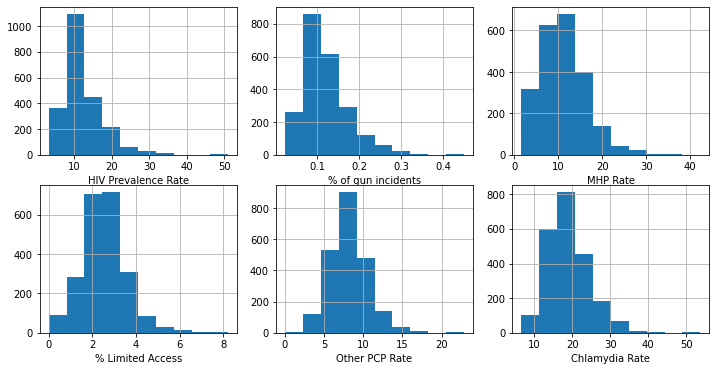

In [268]:
sqrt_HIV = np.sqrt(countyHealthFinal_df['HIV Prevalence Rate'])
plt.rcParams['figure.figsize'] = (12,6)
plt.subplot(2, 3, 1)
plt.xlabel('HIV Prevalence Rate')
sqrt_HIV.hist()

plt.subplot(2, 3, 2)
sqrt_perc_inc = np.sqrt(countyHealthFinal_df.perc_incidents)
plt.xlabel('% of gun incidents')
sqrt_perc_inc.hist()

plt.subplot(2, 3, 3)
sqrt_MHP = np.sqrt(countyHealthFinal_df['MHP Rate'])
plt.xlabel('MHP Rate')
sqrt_MHP.hist()

sqrt_perc_LA = np.sqrt(countyHealthFinal_df['% Limited Access'])
plt.subplot(2, 3, 4)
plt.xlabel('% Limited Access')
sqrt_perc_LA.hist()

plt.subplot(2, 3, 5)
sqrt_other_PCP = np.sqrt(countyHealthFinal_df['Other PCP Rate'])
plt.xlabel('Other PCP Rate')
sqrt_other_PCP.hist()

plt.subplot(2, 3, 6)
sqrt_chlamydia = np.sqrt(countyHealthFinal_df['Chlamydia Rate'])
plt.xlabel('Chlamydia Rate')
sqrt_chlamydia.hist()
plt.show()

The distribution looks better for % Limited Access, Other PCP Rate and Chlamydia



### Logarithmic Transformation

Now, we try a log transformation for the columns wihout zeroes to see if there is any improvement over square root transformation.

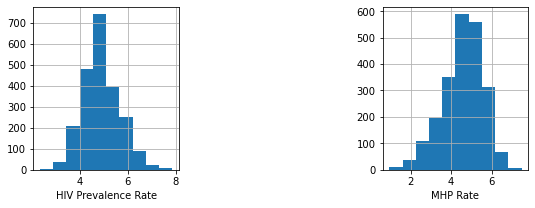

In [269]:
log_HIV = np.log(countyHealthFinal_df['HIV Prevalence Rate'])
plt.rcParams['figure.figsize'] = (12,3)
plt.subplot(1, 4, 1)
plt.xlabel('HIV Prevalence Rate')
log_HIV.hist()


plt.subplot(1, 4, 3)
log_MHP = np.log(countyHealthFinal_df['MHP Rate'])
plt.xlabel('MHP Rate')
log_MHP.hist()
plt.show()

Now, the distribution for HIV and MHP look better.

### View plot for transformed data

Following the data transformation, the outliers are also reduced.

In [270]:
plt.rcParams['figure.figsize'] = (10,3);
plt.subplot(1, 3, 1)
plt.xlabel('HIV Prevalence Rate')
plt.ylabel('% of gun incidents')
plt.scatter(log_HIV, sqrt_perc_inc,s=30, alpha=0.3, linewidth=0);

plt.subplot(1, 3, 2)
plt.xlabel('MHP Rate')
plt.scatter(log_MHP, sqrt_perc_inc,s=30, alpha=0.3, linewidth=0);

plt.subplot(1, 3, 3)
plt.xlabel('Chlamydia Rate')
plt.scatter(sqrt_chlamydia, sqrt_perc_inc,s=30, alpha=0.3, linewidth=0);
plt.show()

### Update dataframe with transformed data

In [271]:
countyHealthFinal_df['% Limited Access'] = np.sqrt(countyHealthFinal_df['% Limited Access'])
countyHealthFinal_df['Other PCP Rate'] = np.sqrt(countyHealthFinal_df['Other PCP Rate'])
countyHealthFinal_df['Chlamydia Rate'] = np.sqrt(countyHealthFinal_df['Chlamydia Rate'])
countyHealthFinal_df['HIV Prevalence Rate'] = np.log(countyHealthFinal_df['HIV Prevalence Rate'])
countyHealthFinal_df['MHP Rate'] = np.log(countyHealthFinal_df['MHP Rate'])
countyHealthFinal_df.perc_incidents = np.sqrt(countyHealthFinal_df.perc_incidents)

In [272]:
countyHealthFinal_df.head()

,FIPS,State,County,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,Perc_LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,% Uninsured,PCP Rate,Dentist Rate,MHP Rate,Preventable Hosp. Rate,% Receiving HbA1c,% Mammography,Age-Adjusted Mortality,Child Mortality Rate,Infant Mortality Rate,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,Costs,Other PCP Rate,Population,n_killed,n_injured,n_incidents,perc_killed,perc_injured,perc_incidents
0,1001,Alabama,Autauga,9409.294766,18.411124,4.200578,4.306739,8.594631,19.124658,36.4,7.1,30.9,71.120192,16.878015,26.785714,18.471600,27.996758,9.387712,45.16957,32.48159,2.536212,81.85,83.966245,62.693157,449.6,56.186903,7.718502,12.824434,12.638357,12.4,5.418320,13.9,3.462820,10.231226,5.0,20.167754,35.905406,10674.34,5.373316,55416,8,6,13,0.014436,0.010827,0.153163
1,1003,Alabama,Baldwin,7467.596664,18.060458,4.098748,4.249649,8.480290,16.795485,29.3,7.9,24.5,68.518915,16.714969,30.379747,18.406521,31.965138,11.524397,72.65266,49.38556,4.490676,46.30,83.212237,65.965233,351.3,47.688777,5.545407,12.622002,12.822558,11.1,5.099256,13.0,2.329040,18.452504,10.0,15.281185,33.305868,9537.12,6.605445,208563,12,6,28,0.005754,0.002877,0.115867
2,1005,Alabama,Barbour,8929.474982,25.773416,5.067438,4.634994,11.741294,21.540878,44.2,5.5,30.6,52.842627,12.698715,35.714286,23.619907,50.189205,13.310452,41.52667,34.66205,2.041568,58.44,89.142857,63.030303,433.6,66.595631,6.483654,16.216160,14.632311,18.2,6.077642,23.4,3.277143,17.406440,4.0,18.597830,38.563167,9790.62,5.192241,25965,0,7,10,0.000000,0.026959,0.196248
3,1007,Alabama,Bibb,11741.938889,19.996912,4.363377,4.315710,11.258278,19.916404,38.4,7.6,37.5,48.592625,15.925151,27.586207,17.381024,47.260274,11.855881,53.13732,22.08188,2.178466,92.87,81.981982,61.306533,529.1,116.315956,14.775414,13.162968,12.854036,14.6,5.256974,16.1,1.612956,22.146105,8.0,27.125572,38.148865,10755.78,8.664779,22643,2,0,2,0.008833,0.000000,0.093983
4,1009,Alabama,Blount,9359.122343,21.095323,4.512753,4.701599,7.791667,19.652158,35.8,8.5,29.0,32.272077,15.378722,20.000000,10.691118,39.624778,13.963659,20.80696,19.06280,2.159282,57.82,87.659574,59.584296,480.2,55.375074,5.294367,13.720057,13.827943,14.4,4.558079,11.3,1.697100,21.375422,8.0,22.536300,35.945010,10326.33,3.482940,57704,1,2,5,0.001733,0.003466,0.093086


### Rescale Data

Since, two of the features are larger than the rest by a factor of 1000, we scale them down so that PCA will come out accurately.

In [273]:
countyHealthFinal_df['Years of Potential Life Lost Rate'] = countyHealthFinal_df['Years of Potential Life Lost Rate']/1000
countyHealthFinal_df['Costs'] = countyHealthFinal_df['Costs']/1000
countyHealthFinal_df.rename(columns={'Years of Potential Life Lost Rate':'Years of Potential Life Lost Rate 1000s', 
                                  'Costs':'Costs 1000s'}, inplace=True);

Two other features are larger than the rest by a factor of 10, so we divide these by 10.

In [274]:
countyHealthFinal_df['MHP Rate'] = countyHealthFinal_df['MHP Rate']/10
countyHealthFinal_df['Age-Adjusted Mortality'] = countyHealthFinal_df['Age-Adjusted Mortality']/10
countyHealthFinal_df.rename(columns={'MHP Rate':'MHP Rate 10s', 'Age-Adjusted Mortality':'Age-Adjusted Mortality 10s'}, 
                         inplace=True);

In [275]:
countyHealthFinal_df.head()

,FIPS,State,County,Years of Potential Life Lost Rate 1000s,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,Perc_LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,% Uninsured,PCP Rate,Dentist Rate,MHP Rate 10s,Preventable Hosp. Rate,% Receiving HbA1c,% Mammography,Age-Adjusted Mortality 10s,Child Mortality Rate,Infant Mortality Rate,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,Costs 1000s,Other PCP Rate,Population,n_killed,n_injured,n_incidents,perc_killed,perc_injured,perc_incidents
0,1001,Alabama,Autauga,9.409295,18.411124,4.200578,4.306739,8.594631,19.124658,36.4,7.1,30.9,71.120192,16.878015,26.785714,18.471600,27.996758,9.387712,45.16957,32.48159,0.253621,81.85,83.966245,62.693157,44.96,56.186903,7.718502,12.824434,12.638357,12.4,5.418320,13.9,3.462820,10.231226,5.0,20.167754,35.905406,10.67434,5.373316,55416,8,6,13,0.014436,0.010827,0.153163
1,1003,Alabama,Baldwin,7.467597,18.060458,4.098748,4.249649,8.480290,16.795485,29.3,7.9,24.5,68.518915,16.714969,30.379747,18.406521,31.965138,11.524397,72.65266,49.38556,0.449068,46.30,83.212237,65.965233,35.13,47.688777,5.545407,12.622002,12.822558,11.1,5.099256,13.0,2.329040,18.452504,10.0,15.281185,33.305868,9.53712,6.605445,208563,12,6,28,0.005754,0.002877,0.115867
2,1005,Alabama,Barbour,8.929475,25.773416,5.067438,4.634994,11.741294,21.540878,44.2,5.5,30.6,52.842627,12.698715,35.714286,23.619907,50.189205,13.310452,41.52667,34.66205,0.204157,58.44,89.142857,63.030303,43.36,66.595631,6.483654,16.216160,14.632311,18.2,6.077642,23.4,3.277143,17.406440,4.0,18.597830,38.563167,9.79062,5.192241,25965,0,7,10,0.000000,0.026959,0.196248
3,1007,Alabama,Bibb,11.741939,19.996912,4.363377,4.315710,11.258278,19.916404,38.4,7.6,37.5,48.592625,15.925151,27.586207,17.381024,47.260274,11.855881,53.13732,22.08188,0.217847,92.87,81.981982,61.306533,52.91,116.315956,14.775414,13.162968,12.854036,14.6,5.256974,16.1,1.612956,22.146105,8.0,27.125572,38.148865,10.75578,8.664779,22643,2,0,2,0.008833,0.000000,0.093983
4,1009,Alabama,Blount,9.359122,21.095323,4.512753,4.701599,7.791667,19.652158,35.8,8.5,29.0,32.272077,15.378722,20.000000,10.691118,39.624778,13.963659,20.80696,19.06280,0.215928,57.82,87.659574,59.584296,48.02,55.375074,5.294367,13.720057,13.827943,14.4,4.558079,11.3,1.697100,21.375422,8.0,22.536300,35.945010,10.32633,3.482940,57704,1,2,5,0.001733,0.003466,0.093086


## Feature Engineering

In this section, we remove highly correlated features before using PCA to find features with the highest loadings. We also look for features with the highest correlations to the target. We use both these features for feature se;ection to build two different models and compare accuracy.

### Check for highly correlated features

We run a correlation matrix to remove highly correlated features for more accurate PCA results.

In [276]:
# copy only those fields to check in correlation matrix into new dataframe.
countyHealth_corr = countyHealthFinal_df.iloc[:,3:39];

In [277]:
countyHealth_corr.corr()

,Years of Potential Life Lost Rate 1000s,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,Perc_LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,% Uninsured,PCP Rate,Dentist Rate,MHP Rate 10s,Preventable Hosp. Rate,% Receiving HbA1c,% Mammography,Age-Adjusted Mortality 10s,Child Mortality Rate,Infant Mortality Rate,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,Costs 1000s,Other PCP Rate
Years of Potential Life Lost Rate 1000s,1.000000,0.715043,0.709925,0.655793,0.588949,0.697432,0.567578,-0.586048,0.657907,-0.450797,-0.614351,-0.013769,0.315349,0.729453,0.365702,-0.332113,-0.345076,-0.235596,0.554434,-0.366386,-0.415211,0.943874,0.648604,0.482076,0.731338,0.737395,0.683355,0.164630,0.646187,0.234315,0.332217,0.364677,0.683782,0.483390,0.429789,0.015474
% Fair/Poor,0.715043,1.000000,0.882370,0.743540,0.635164,0.729476,0.552240,-0.636804,0.623270,-0.425632,-0.687882,-0.073457,0.399912,0.756907,0.483273,-0.342607,-0.334809,-0.239498,0.491181,-0.318162,-0.442055,0.746206,0.480840,0.372597,0.930289,0.851159,0.641715,0.277340,0.680497,0.263819,0.152914,0.170848,0.523312,0.639676,0.423984,-0.025689
Physically Unhealthy Days,0.709925,0.882370,1.000000,0.909676,0.501923,0.799885,0.523722,-0.564546,0.595981,-0.402007,-0.670644,-0.035641,0.248850,0.658196,0.323361,-0.308343,-0.320991,-0.172988,0.520904,-0.316871,-0.398703,0.744812,0.427990,0.339732,0.982416,0.947491,0.646955,0.108438,0.623973,0.207225,0.255600,0.342435,0.483104,0.639371,0.369769,0.012088
Mentally Unhealthy Days,0.655793,0.743540,0.909676,1.000000,0.463830,0.734955,0.496314,-0.480383,0.567872,-0.369651,-0.646360,-0.048122,0.195939,0.517471,0.196141,-0.252874,-0.282491,-0.092988,0.466201,-0.235923,-0.282975,0.687827,0.362772,0.330617,0.872494,0.951710,0.657381,0.095916,0.580397,0.120621,0.315625,0.402196,0.405747,0.631973,0.349390,0.027734
Perc_LBW,0.588949,0.635164,0.501923,0.463830,1.000000,0.474181,0.401565,-0.540651,0.477451,-0.301666,-0.553535,-0.072781,0.424140,0.498593,0.284670,-0.193161,-0.230771,-0.184959,0.320300,-0.121755,-0.196282,0.599987,0.441480,0.423500,0.547495,0.529721,0.572659,0.485017,0.652149,0.150447,0.148309,0.092799,0.373312,0.558590,0.384089,0.002550
% Smokers,0.697432,0.729476,0.799885,0.734955,0.474181,1.000000,0.639976,-0.497776,0.649636,-0.394508,-0.475604,0.029866,0.264755,0.602884,0.220777,-0.306174,-0.346840,-0.210767,0.561544,-0.252602,-0.295862,0.747493,0.486568,0.412104,0.805663,0.808560,0.629501,0.071841,0.561060,0.159899,0.247681,0.219545,0.445426,0.618193,0.366374,0.050656
% Obese,0.567578,0.552240,0.523722,0.496314,0.401565,0.639976,1.000000,-0.360714,0.714727,-0.454623,-0.453404,-0.012786,0.205232,0.505567,0.132095,-0.407905,-0.390685,-0.314436,0.485719,-0.097329,-0.208701,0.618123,0.431640,0.402513,0.528940,0.539184,0.723178,0.029080,0.432565,0.113253,0.143586,0.003328,0.464635,0.501250,0.404640,-0.096511
Food Environment Index,-0.586048,-0.636804,-0.564546,-0.480383,-0.540651,-0.497776,-0.360714,1.000000,-0.372853,0.299908,0.471082,0.000629,-0.536030,-0.509766,-0.439864,0.147793,0.149472,0.022862,-0.253993,0.352714,0.306073,-0.583895,-0.467866,-0.353535,-0.624207,-0.609901,-0.432732,-0.358712,-0.864333,-0.710615,-0.021060,-0.080377,-0.386935,-0.364674,-0.206890,-0.079911
% Physically Inactive,0.657907,0.623270,0.595981,0.567872,0.477451,0.649636,0.714727,-0.372853,1.000000,-0.516776,-0.591565,-0.113373,0.103423,0.606836,0.290842,-0.475649,-0.486293,-0.415275,0.588730,-0.135037,-0.334515,0.713879,0.444473,0.404943,0.596208,0.593950,0.761604,0.077334,0.461401,0.083858,0.187034,0.133865,0.567405,0.486420,0.558898,-0.134837
% With Access,-0.450797,-0.425632,-0.402007,-0.369651,-0.301666,-0.394508,-0.454623,0.299908,-0.516776,1.000000,0.398119,0.0292

In [278]:
# remove highly correlated features

countyHealth_corr = countyHealth_corr.drop(columns=['Years of Potential Life Lost Rate 1000s','% Fair/Poor',
                                                      'Mentally Unhealthy Days', 'Food Environment Index',
                                                      '% Frequent Physical Distress','% Frequent Mental Distress'])

In [279]:
countyHealth_corr.head()

,Physically Unhealthy Days,Perc_LBW,% Smokers,% Obese,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,% Uninsured,PCP Rate,Dentist Rate,MHP Rate 10s,Preventable Hosp. Rate,% Receiving HbA1c,% Mammography,Age-Adjusted Mortality 10s,Child Mortality Rate,Infant Mortality Rate,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,Costs 1000s,Other PCP Rate
0,4.200578,8.594631,19.124658,36.4,30.9,71.120192,16.878015,26.785714,18.471600,27.996758,9.387712,45.16957,32.48159,0.253621,81.85,83.966245,62.693157,44.96,56.186903,7.718502,12.4,5.418320,13.9,3.462820,10.231226,5.0,20.167754,35.905406,10.67434,5.373316
1,4.098748,8.480290,16.795485,29.3,24.5,68.518915,16.714969,30.379747,18.406521,31.965138,11.524397,72.65266,49.38556,0.449068,46.30,83.212237,65.965233,35.13,47.688777,5.545407,11.1,5.099256,13.0,2.329040,18.452504,10.0,15.281185,33.305868,9.53712,6.605445
2,5.067438,11.741294,21.540878,44.2,30.6,52.842627,12.698715,35.714286,23.619907,50.189205,13.310452,41.52667,34.66205,0.204157,58.44,89.142857,63.030303,43.36,66.595631,6.483654,18.2,6.077642,23.4,3.277143,17.406440,4.0,18.597830,38.563167,9.79062,5.192241
3,4.363377,11.258278,19.916404,38.4,37.5,48.592625,15.925151,27.586207,17.381024,47.260274,11.855881,53.13732,22.08188,0.217847,92.87,81.981982,61.306533,52.91,116.315956,14.775414,14.6,5.256974,16.1,1.612956,22.146105,8.0,27.125572,38.148865,10.75578,8.664779
4,4.512753,7.791667,19.652158,35.8,29.0,32.272077,15.378722,20.000000,10.691118,39.624778,13.963659,20.80696,19.06280,0.215928,57.82,87.659574,59.584296,48.02,55.375074,5.294367,14.4,4.558079,11.3,1.697100,21.375422,8.0,22.536300,35.945010,10.32633,3.482940


### Use PCA for feature selection

Next, we use PCA to identigy the features with highest component loadings.

In [280]:
# Use PCA to identify most important features
pca = PCA(n_components=2)
pca.fit(countyHealth_corr);
pca_loadings = pd.DataFrame(countyHealth_corr.columns.values, np.abs(pca.components_[0]));
print("Absolute value of PCA Loadings: ", pca_loadings.sort_index(0)[::-1])

Absolute value of PCA Loadings:                                             0
0.621329                            PCP Rate
0.487579                        Dentist Rate
0.350991                       % With Access
0.313452              Preventable Hosp. Rate
0.212094                     Teen Birth Rate
0.198183                Child Mortality Rate
0.158821          Age-Adjusted Mortality 10s
0.127359                   MV Mortality Rate
0.086113               % Physically Inactive
0.074320                       % Mammography
0.062736                             % Obese
0.045621                           % Smokers
0.040042                         % Uninsured
0.037924                % Excessive Drinking
0.037250                          % Diabetic
0.036862                     % Food Insecure
0.032880                % Insufficient Sleep
0.027149                   % Receiving HbA1c
0.026950        Drug Overdose Mortality Rate
0.024445                      Other PCP Rate
0.019907              

/var/folders/7y/t_w5wzf93z30j10_stv45xww0000gn/T/ipykernel_89793/1315701849.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only



### Features Selected by both methods

Based on PCA, the most important features are:
<ul>
<li>Primary Care Provider Rate : 0.6213285765132028
<li>Dentist Rate : 0.4875786392411785
<li>% With Exercise Access : 0.3509913861191063
<li>Preventable Hospital Rate : -0.31345230204955465
<li>Teen Birth Rate : -0.21209386807636513
<li>Child Mortality Rate : -0.19818320365100658
<li>Age-Adjusted Mortality 10s : -0.15882087626508506
<li>Motor Vehicle Mortality Rate : -0.1273592405079525
<li>% Physically Inactive : -0.08611275273507477
<li>% Mammography : 0.0743197803660411
    </ul>
    
Based on the correlation matrix, the highest ranked features correlated to % gun incidents are:
<ul>
<li>Strong positive correlation: Chlamydia (r=0.45);
<li>Moderate positive correlation: % Food Insecure (r=0.37), HIV Prevalence Rate (r=0.36), % Low Birth Weight (r=0.35);
<li>Moderate negative correlation: Food Environment Index (r = -0.38);
<li>Weak Positive correlation: Other PCP Rate (r=0.285), Infant Mortality Rate (r=0.281), Child Mortality Rate (r=0.28)
    </ul>

# Model Building

In this section, we build multiple regression models using features selected from PCA and correlation rankings and compare both models to find the one with greater accuracy.

### Model 1 : Features from PCA

Here, we added features one at a time in order of importance until the R-squared no longer increased. This resulted in the top 8 features being used.

In [281]:
featuresPCA = countyHealthFinal_df[['PCP Rate', 'Dentist Rate','% With Access','Preventable Hosp. Rate','Teen Birth Rate',
                             'Child Mortality Rate','Age-Adjusted Mortality 10s','MV Mortality Rate']]

### Split data and fit model

We split the data into 10 folds and use cross-validation to check the Mean Squared Error and R-squared.

In [282]:
# split into test and training sets
X = featuresPCA
y = countyHealthFinal_df.perc_incidents
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gun_health_model1 = sm.OLS(y_train,X_train).fit()
    print("Mean Squared Error: ", gun_health_model1.mse_total, "   R-squared: ", gun_health_model1.rsquared)

Mean Squared Error:  0.016872917138858495    R-squared:  0.8594328944212083
Mean Squared Error:  0.01707331727371441    R-squared:  0.8606657401456469
Mean Squared Error:  0.01726063439928777    R-squared:  0.8634781293636894
Mean Squared Error:  0.017025915525273595    R-squared:  0.8585868025455754
Mean Squared Error:  0.017122201987858753    R-squared:  0.8601891924000551
Mean Squared Error:  0.01743517297816935    R-squared:  0.8631379482836855
Mean Squared Error:  0.01731660049560303    R-squared:  0.8625315254952624
Mean Squared Error:  0.017178659408954106    R-squared:  0.8611530083971634
Mean Squared Error:  0.017880156499809865    R-squared:  0.861661501417743
Mean Squared Error:  0.017404879357076034    R-squared:  0.8596547367422094


The results above are consistent over the 10 folds with errors around 0.017 and R-squared at 0.86. This shows the model explains 86% of the variance in the target.

### Prediction and test error

Next, we use another model to predict test values, calculate the test error and visualise the actuals versus the predicted values.

In [283]:
# predict test values
y_prediction = gun_health_model1.predict(X_test)

# calculate error between actual and prediction
error = (y_prediction - y_test)/y_test*100
avg_error = np.sum(error)/2238
print("Model1 has an average error of:", avg_error, "%")

Model1 has an average error of: 2.462895550594189 %


In [284]:
y_test.dtypes

dtype('float64')

In [285]:
# ccatter plot of model1 test prediction
plt.rcParams['figure.figsize'] = (6,4);
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model 1 Predicted vs Actual')
plt.scatter(y_test, y_prediction, s=30, linewidth=0);

### Model 2 : Features selected with Correlation

Here, we added features one at a time in order of highest correlation until the R-squared no longer increased. This resulted in the top 7 features being used.

In [286]:
featuresCorrelation = countyHealthFinal_df[['Chlamydia Rate', '% Food Insecure', 'HIV Prevalence Rate', 'Perc_LBW','Food Environment Index',
                             'Other PCP Rate','Infant Mortality Rate']]

### Split data and fit model

I split data into 10 folds and use cross-validation to check the Mean Squared Error and R-squared. 

In [287]:
#Split into test and training sets
X = featuresCorrelation
y = countyHealthFinal_df.perc_incidents
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gun_health_model2 = sm.OLS(y_train,X_train).fit()
    print("Mean Squared Error: ", gun_health_model2.mse_total, "   R-squared: ", gun_health_model2.rsquared)

Mean Squared Error:  0.016872917138858495    R-squared:  0.8826502383034998
Mean Squared Error:  0.01707331727371441    R-squared:  0.8802815249101124
Mean Squared Error:  0.01726063439928777    R-squared:  0.8841264380270324
Mean Squared Error:  0.017025915525273595    R-squared:  0.88115008202186
Mean Squared Error:  0.017122201987858753    R-squared:  0.8803405404492646
Mean Squared Error:  0.01743517297816935    R-squared:  0.8851043648498265
Mean Squared Error:  0.01731660049560303    R-squared:  0.8823683632151161
Mean Squared Error:  0.017178659408954106    R-squared:  0.8805673720318393
Mean Squared Error:  0.017880156499809865    R-squared:  0.8836829171605943
Mean Squared Error:  0.017404879357076034    R-squared:  0.8800209680309821


### Prediction and test error

Next, we use this to predict test values, calculate the test error and visualise the actuals versus the predicted values.

In [288]:
# Predict test values
y_prediction = gun_health_model2.predict(X_test)

# Calculate error between actual and predicted values
error = (y_prediction - y_test)/y_test*100
avg_error = np.sum(error)/2238
print("Model2 has an average error of:", avg_error, "%")

Model2 has an average error of: 1.5042929928975883 %


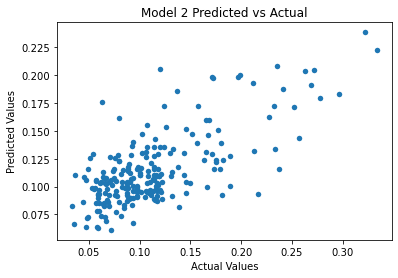

In [289]:
# Scatter plot of model2 test prediction
plt.rcParams['figure.figsize'] = (6,4);
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model 2 Predicted vs Actual')
plt.scatter(y_test, y_prediction,s=30, linewidth=0);

# Evaluation and Validation of Results

Both models above perform well, but Model 2 performs slightly better with a higher R-squared and lower error.

In **Model 1**, the most important features are: Primary Care Physician Rate, Dentist Rate, % With Access to Exercise Opportunities, Preventable Hospital Stays Rate, Teen Birth Rate, Child Mortality Rate, Age-Adjusted Mortality and Motor Vehicle Mortality Rate. These eight features represent **86% of the variance in the gun violence data with an average test error of 2.5%.**

In **Model 2**, the most important features are: Chlamydia Rate, % Food Insecure, HIV Prevalence Rate, % Low Birth Weight, Food Environment Index, Other Primary Care Providers Rate and Infant Mortality Rate. These six features represent **88% of the variance in the gun violence data with an average test error of 1.5%.**
    